# Exercise: Features and supervised learning

In this exercise we look at different methods for extracting features from images and using them for supervised learning. We well concentrate mainly on example images from textures and try to discriminate between different textures.

In the first exercise we will lokk at binary local patterns and in the second exercise we will gather features from the glcm and train a classifier.


In [20]:
import numpy as np
import scipy.stats
import skimage
import skimage.data
import skimage.io
import skimage.future
import skimage.segmentation
import skimage.feature
import sklearn.cluster
import cv2

# for displaying images in jupyter
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
#mpl.rcParams['figure.dpi']= 400

## Exercise 1: Texture Recognition using Binary Local Patterns and Histograms

In this exercise we will look at texture images from two different classes and extract the binary local patterns.

We first load two images from the *describable texture database (dtd)*.

You can either download the whole data set from
https://www.robots.ox.ac.uk/~vgg/data/dtd/ or use the 2 images provided on Moodle. (you might have to update the path, depending on where you store the data)

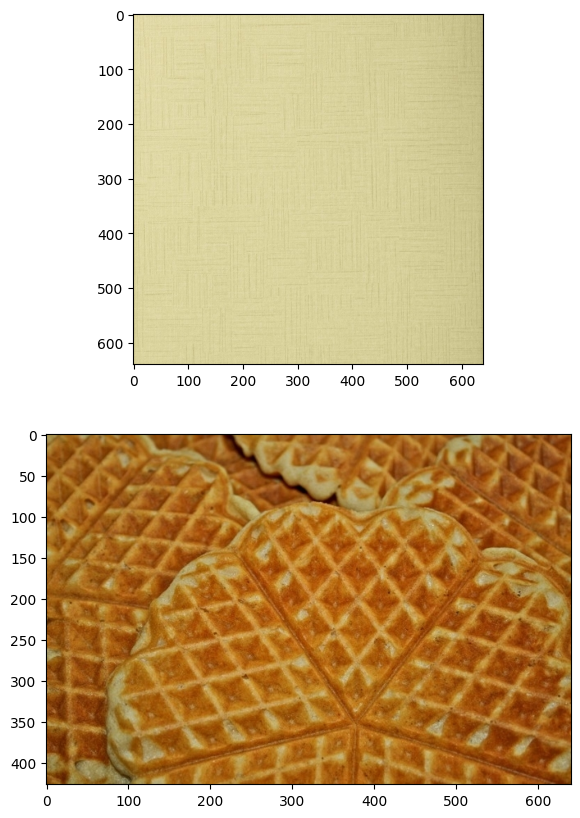

In [21]:
im_1 = skimage.io.imread('images/crosshatched_0044.jpg')
im_2 = skimage.io.imread('images/waffled_0029.jpg')

plt.subplot(2, 1, 1)
plt.imshow(im_1)
plt.subplot(2, 1, 2)
plt.imshow(im_2)

### Use grayscale images

We will only use the gray images, so we will convert them to grayscale. By default, this will turn them into float64 images if we use the ```skimage.color.rgb2gray``` function. As we want to continue to work with 8bit images, we convert them back to ubyte using ```skimage.img_as_ubyte```:

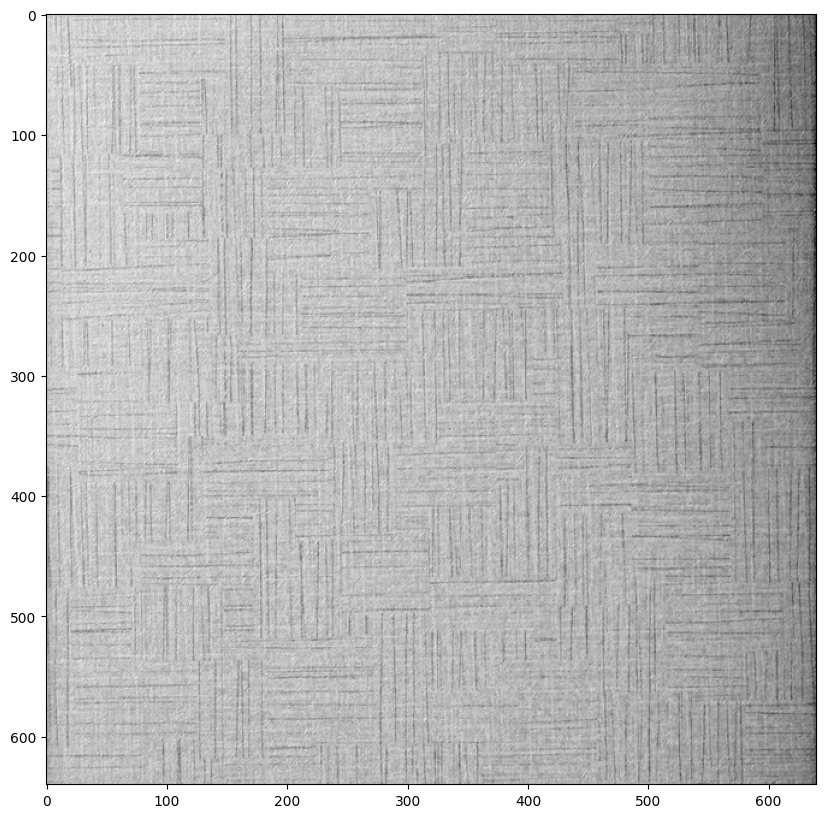

In [22]:
im_1_gray = skimage.img_as_ubyte(skimage.color.rgb2gray(im_1))
plt.imshow(im_1_gray, cmap='gray')

### Exercise 1.1. Convert to grayscale

Do the same for the other image.

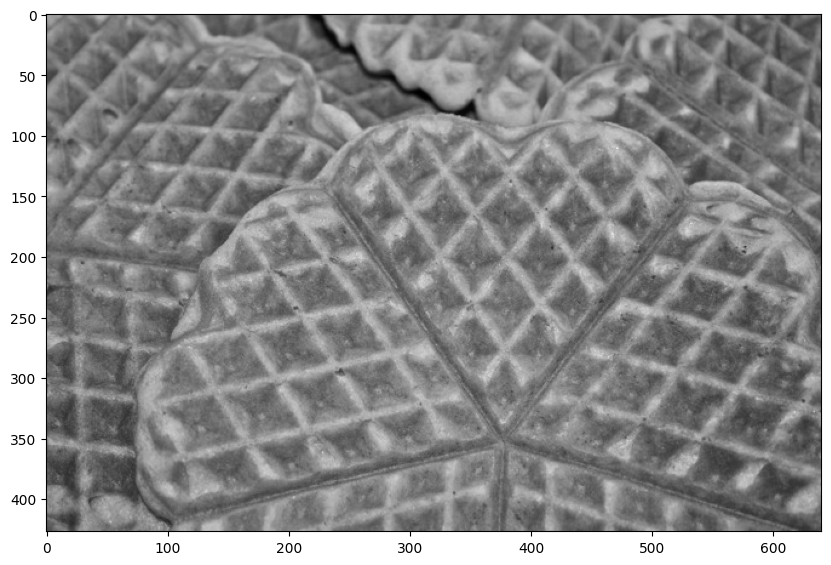

In [23]:
im_2_gray = skimage.img_as_ubyte(skimage.color.rgb2gray(im_2))
plt.imshow(im_2_gray, cmap='gray')

### Exercise 1.2 Calculate the local binary patterns (LBP)

Calculate the local binary patterns using the function ```skimage.feature.local_binary_pattern```. Check the description of the function for different variants of the pattern calculation. 

Visualize the patterns as image. What is the range of the resulting data? Do you think we could we use the values directly to distinquish between the two textures?

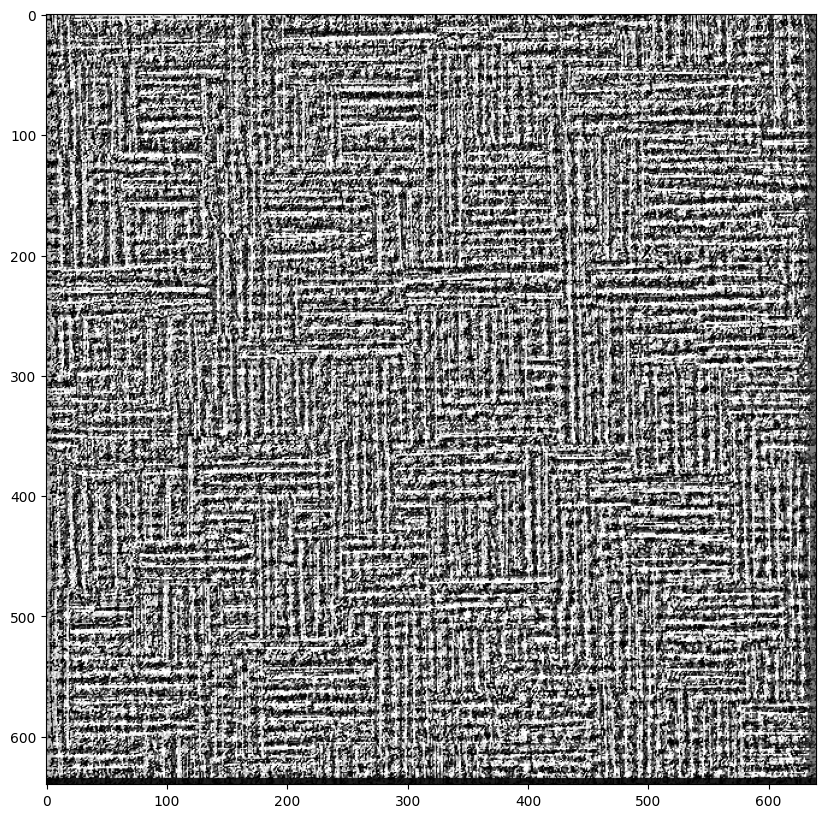

In [24]:
lbp = skimage.feature.local_binary_pattern(im_1_gray, 8, 6)
plt.imshow(lbp, cmap='gray')

### Exercise 1.3: Texture Segmentation with LBP

In order to use the LBP for (texture) segmentation, we can not use the pixel values directly. So an often used approach is to use the histogram of the LBP as feature. For texture segmentation we want to calculate this histogram on a subwindow.


#### Sliding window approach

For a sliding window approach, skimage provides two utility function to calculate blocks from an image. One is ```skimage.util.view_as_blocks``` that divides the image into non-overlapping blocks and the other is ```skimage.util.view_as_windows``` that divides the image into overlapping windows. For the latter approach, we have to be careful to not generate too many windows, so in the sliding window approach we often use some step value greater than 1.

Use the function ```skimage.util.view_as_blocks``` and see how to access the blocks. Plot the blocks as images.



(8, 8, 80, 80)


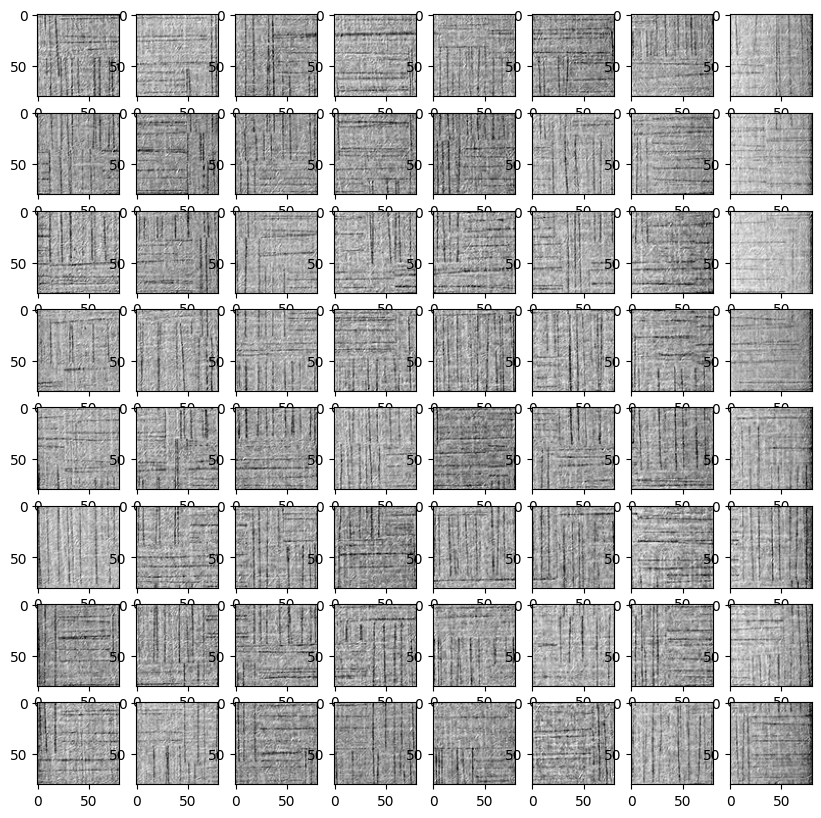

In [25]:
blocks = skimage.util.view_as_blocks(im_1_gray, block_shape=(80, 80))
print(blocks.shape)

index = 1
for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
        plt.subplot(blocks.shape[0], blocks.shape[1], index)
        plt.imshow(blocks[i, j], cmap='gray')
        index += 1

Try the same with the function ```skimage.util.view_as_windows```. What could be the advantage of this function over the other one?

(11, 11, 80, 80)


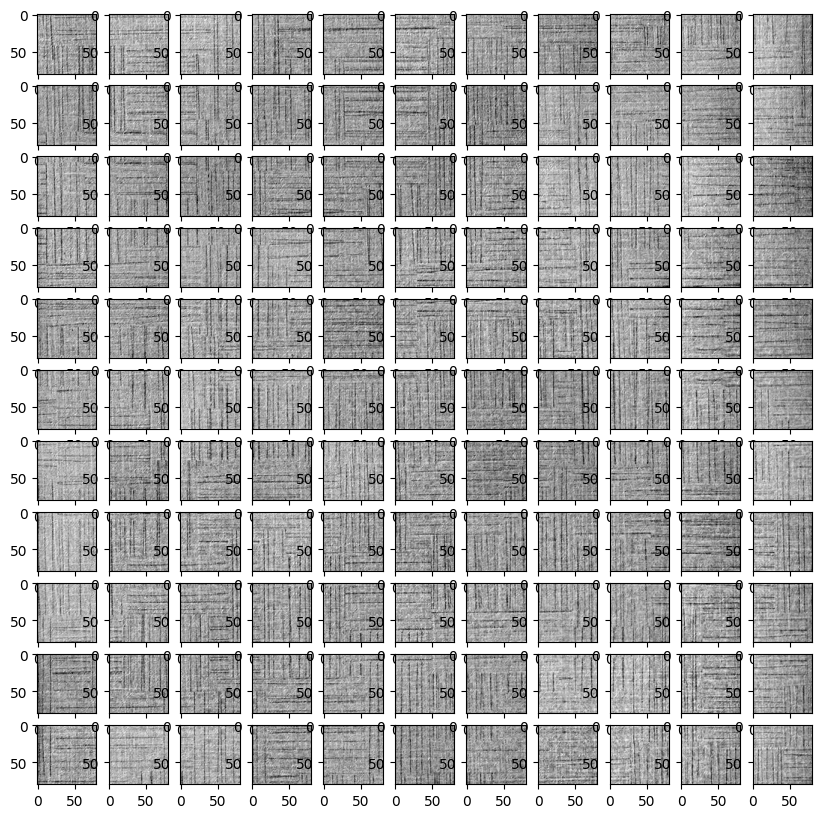

In [26]:
windows = skimage.util.view_as_windows(im_1_gray, window_shape=(80, 80), step=54)
print(windows.shape)

index = 1
for i in range(windows.shape[0]):
    for j in range(windows.shape[1]):
        plt.subplot(windows.shape[0], windows.shape[1], index)
        plt.imshow(windows[i, j], cmap='gray')
        index += 1

#### Histogram calculation
Calculate the histogram (```np.histogram```) of the LBP in 2 subwindows of the first image and then in two subwindows of the second texture image and plot all four histograms. Use 255 bins for the histogram. ```np.histogram``` returns both the histogram values and the edges of the bins, there is one more edge than number of bins)

Plot the resulting histograms.


In [27]:
# Solution
hist_block_1, bins_block_1 = np.histogram(blocks[0, 0], bins=255)
hist_block_2, bins_block_2 = np.histogram(blocks[1, 0], bins=255)

hist_window_1, bins_window_1 = np.histogram(windows[0, 0], bins=255)
hist_window_2, bins_window_2 = np.histogram(windows[1, 0], bins=255)

Text(0.5, 1.0, 'view_as_windows (1,0)')

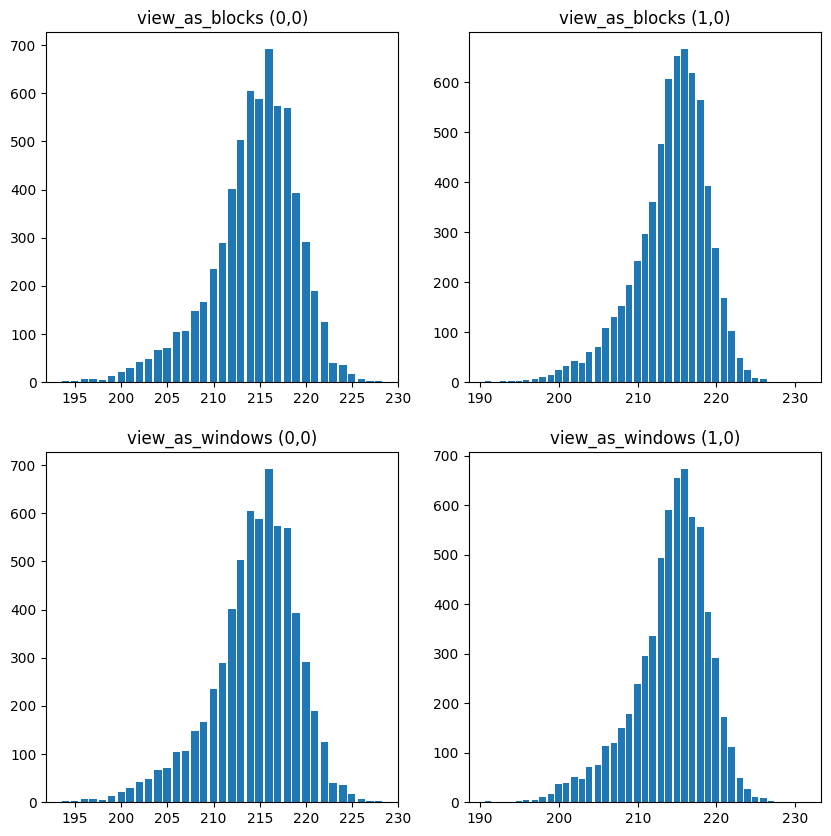

In [28]:
# plot side by side
plt.subplot(2, 2, 1)
plt.bar(bins_block_1[:-1], hist_block_1)
plt.title('view_as_blocks (0,0)')
plt.subplot(2, 2, 2)
plt.bar(bins_block_2[:-1], hist_block_2)
plt.title('view_as_blocks (1,0)')
plt.subplot(2, 2, 3)
plt.bar(bins_window_1[:-1], hist_window_1)
plt.title('view_as_windows (0,0)')
plt.subplot(2, 2, 4)
plt.bar(bins_window_2[:-1], hist_window_2)
plt.title('view_as_windows (1,0)')

#### Histogram comparison

There are different functions to compare histograms. One possibility is ```scipy.stats.chisquare``` for the so called chi square difference. Other implementation of histogram comparisons are available in OpenCV (https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html).

If you want to use the ```scipy.stats.chisquare```, it will fail if any of the histogram values are 0. This can be solved by adding 1 to the histogram.

Calculate the histogram differences between histograms from the same image and the histogram from different images. 

Are the results as expected?


In [29]:
hist_block_1, bins_block_1 = np.histogram(blocks[0, 0], bins=255)
hist_block_2, bins_block_2 = np.histogram(blocks[1, 0], bins=255)
import scipy

block_diff = scipy.stats.chisquare(hist_block_1 + 1, hist_block_2 + 1)
window_diff = scipy.stats.chisquare(hist_window_1 + 1, hist_window_2 + 1)
inter_diff_1 = scipy.stats.chisquare(hist_block_1 + 1, hist_window_1 + 1)
inter_diff_2 = scipy.stats.chisquare(hist_block_2 + 1, hist_window_2 + 1)

print(f'Block 1 diff: {block_diff.statistic:.3f} ')
print(f'Window 2 diff: {window_diff.statistic:.3f} ')
print(f'Inter diff 1 diff: {inter_diff_1.statistic:.3f} ')
print(f'Inter diff 2 diff: {inter_diff_2.statistic:.3f} ')

Block 1 diff: 1870166.917 
Window 2 diff: 1870173.235 
Inter diff 1 diff: 0.000 
Inter diff 2 diff: 26.417 


## Exercise 2: Semantic Segmentation using statistical features, GLCM features and supervised learning

In the next exercise we want to use a feature vector from statistical data and use it for supervised learning. For that we will again use a sliding window approach, so first we divide the images again into sliding window views. Use few windows (i.e. a large step size) first and increase the number of windows when all is implemented. Try a block size for example of 40 by 40 pixels.

In [30]:
windows = skimage.util.view_as_windows(im_1_gray, window_shape=(40, 40), step=20)

### Exercise 2.1: Statistical features

Calculate the mean value (```np.mean```) and the standard deviation (```np.std```) of a block. This will be our first features.

In [31]:
features_dim = np.zeros(windows.shape[0:2])
features_dim.shape

(31, 31)

In [32]:
mean = np.copy(features_dim)
std = np.copy(features_dim)
for i in range(windows.shape[0]):
    for j in range(windows.shape[1]):
        mean[i][j] = np.mean(windows[i][j])
        std[i][j] = np.std(windows[i][j])

In [33]:
mean

array([[215.050625, 214.874375, 214.364375, 214.191875, 214.07375 ,
        214.054375, 213.36875 , 212.615625, 211.914375, 211.31875 ,
        211.124375, 211.238125, 210.939375, 210.131875, 209.533125,
        209.135   , 208.8175  , 208.038125, 207.07625 , 206.30875 ,
        205.656875, 204.698125, 203.285625, 202.298125, 201.619375,
        200.189375, 198.658125, 196.934375, 194.39625 , 190.771875,
        186.39625 ],
       [214.839375, 214.388125, 213.974375, 213.885625, 213.57    ,
        213.0475  , 212.273125, 211.5975  , 211.074375, 210.56    ,
        210.870625, 211.25625 , 211.03    , 210.451875, 209.8975  ,
        209.308125, 208.549375, 207.68875 , 207.178125, 206.7175  ,
        205.545   , 204.481875, 203.39875 , 202.339375, 201.806875,
        200.748125, 199.0325  , 197.044375, 194.380625, 190.42125 ,
        186.2725  ],
       [214.830625, 214.35375 , 213.678125, 213.403125, 213.33375 ,
        212.23875 , 211.350625, 211.11125 , 210.478125, 210.251875,
      

In [34]:
std

array([[4.72499334, 4.03141952, 3.92177968, 3.73915886, 3.96526304,
        4.10854821, 4.62320489, 4.93055584, 4.96218635, 4.51022709,
        4.13251205, 4.4731333 , 4.56625663, 4.56612352, 4.55248863,
        4.29744401, 4.03567761, 4.00536159, 4.13874207, 4.47866313,
        4.37997035, 4.31561079, 4.65808902, 5.01240925, 5.00307402,
        5.24568986, 5.16732489, 4.94090765, 4.72670455, 5.33172899,
        6.49041493],
       [4.84469551, 4.64192675, 4.49151627, 4.35172878, 4.2813666 ,
        4.36766456, 4.89167944, 5.00879165, 5.17253259, 4.88174149,
        4.18107487, 4.15864593, 4.20019047, 4.16940451, 4.08114491,
        4.18054231, 4.18241104, 4.224556  , 4.21561342, 4.52232725,
        4.81318242, 4.50024127, 4.49747134, 4.81408866, 4.59179461,
        4.54281675, 4.81536019, 4.9078922 , 4.88704917, 5.39919424,
        6.22731834],
       [4.76360547, 4.91056116, 4.9523501 , 4.65409661, 4.07444609,
        4.57853671, 4.96640585, 4.79193316, 4.97853106, 4.80309109,
      

### Exercise 2.2. GLCM

Next we want do calculate the GLCM (using skimage.feature.greycomatrix). The matrix is a square nxn matrix, where n is the number of levels. For uint8 images n would be 256, however this is probably too large, we we use only 16 levels which can be achieved by dividing the image by 16 (usind the // operator in python for integer division).

```image = blocks_1_flat[0] // 16```

Calculate a matrix and indicate the correct number of levels. Check the documentation about the arguments.

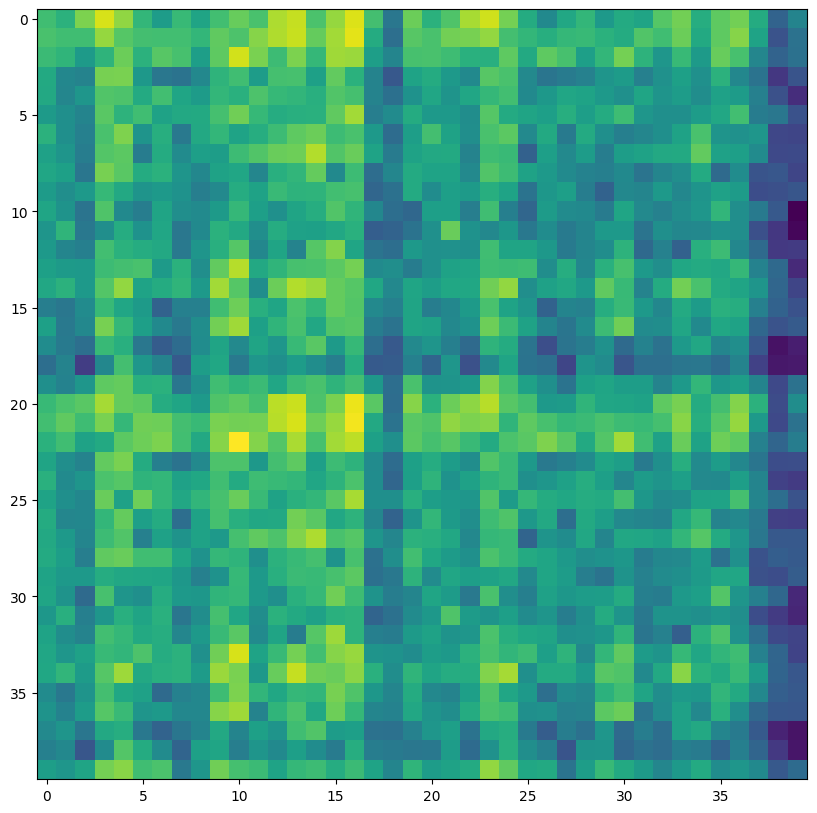

In [35]:
windows_16 = windows // 16
glcm = skimage.feature.graycoprops(windows_16)
plt.imshow(glcm)

#### Multiple GLCMs
It is possible to calculate different GLCMs for different pixel neighborhoods and different orientations. Change the arguments to calculate GLCMs for the distances 1 and 2 pixels and for horizontal and vertical orientations.

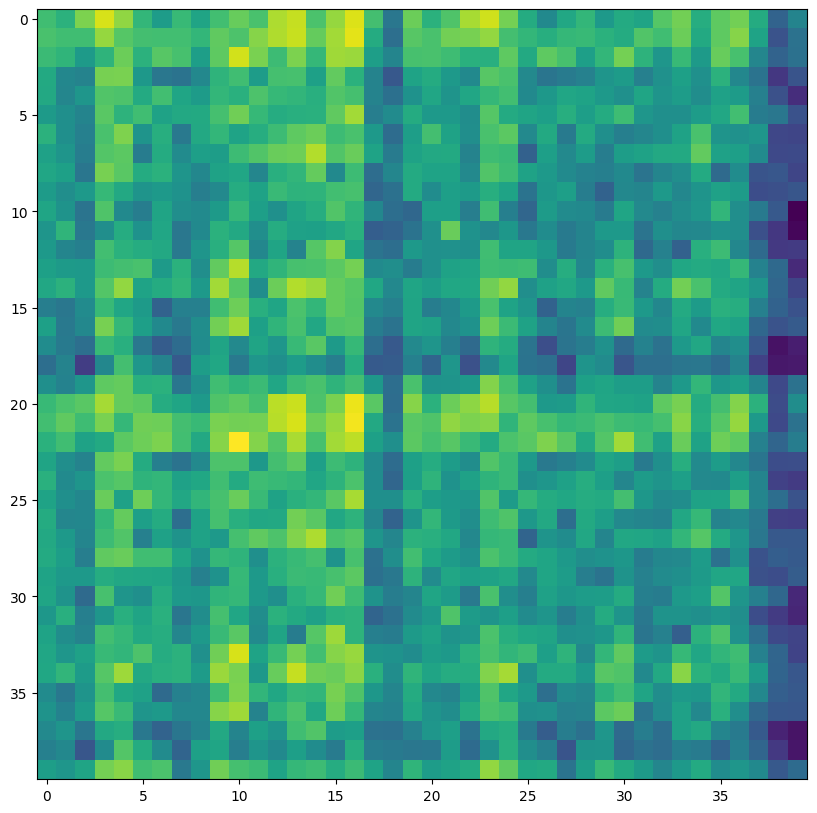

In [36]:
props = {'distances' : [1, 2] }
glcm = skimage.feature.graycoprops(windows_16)
plt.imshow(glcm)

### Exercise 2.3 Features
#### Properties from GLCMs

```skimage.feature.greycoprops``` allows to calculate different features from the GLCM such as contrast and dissimilarity. The full list of supported features is

```['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']```

Calculate those features and print them.

#### Feature calculation
Define a function that takes an input image and calculates a feature vector from it.

In [39]:

def calc_features(image: np.ndarray):
    features = np.asarray([np.mean(image), np.std(image)])
    glcm = skimage.feature.graycoprops(image)
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features = np.concatenate()
    return features


f = calc_features(windows[0] // 16)
print(f.shape)


ValueError: The parameter `P` must be a 4-dimensional array

Calculate the features for every window in the image and put them together to a large vector of features.


In [ ]:
f = [calc_features(image // 16) for image in blocks_1_flat]
data = np.stack(f, axis=0)


#### Complete the data sets for training
For supervised learning, we need a label for each feature, lets assign the first image the label 0 and the second image the label 1. Put together a label vector for the data set 1 and then put together the features and labels for the data set 2. Finally concatenate both data sets and labels together.

### 2.4: Supervised learning

In order to use any of the available supervised learning approaches, we *should* normalize the data (read *must* :-)). There is a function ```sklearn.preprocessing.normalize``` that can do that, alternatively we could normalize the features to be in the range between 0 and 1 when we put then together. 

When using ```sklearn.preprocessing.normalize```, we do not want to normalize individual feature vector (axis=1, the default), but along all values of a feature (axis = 0). So the call should be

```data_norm = sklearn.preprocessing.normalize(data, axis=0)```

Also our data is not shuffled randomly, which might impact the result for some approaches. We can shuffle a data set and the label together using 

```sklearn.utils.shuffle(data, label)```.


#### Classifiers

We are finally ready to train a classifier on the data. We will use a decision tree and a support vector machine. The decision tree is implemented in 

```dtc = sklearn.tree.DecisionTreeClassifier()```

which will return a classifier object that has the member function fit

```dtc.fit(data_s, label_s)```

There a different variants of support vector machines in the package sklearn.svm. For our problem, we can use the LinearSVC:

```svm = sklearn.svm.LinearSVC()```

Train both classifiers and predict the (training) data using 

```dtc.predict(data_s)```.

How good is the result? How do we evaluate the result?

### Exercise 3 (optional): Further evaluation

- The results are probably quite good. How can we look at some of the data to understand the results better?
- Try loading two another images from the same textures and run the classification. Does it still work?